## Analysis and visualization of distance data from AMD and zeolite features

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from zeo_amd.plotting import savefig

plt.style.use("jupyter")

In [2]:
exp = pd.read_csv("../data/iza_dm.csv", index_col=0).sort_index()
efeat = pd.read_csv("../data/iza_features.csv", index_col=0).sort_index()

nnp = pd.read_csv("../data/iza_nnpscan_dm.csv", index_col=0).sort_index()
nfeat = pd.read_csv("../data/iza_features.csv", index_col=0).sort_index()

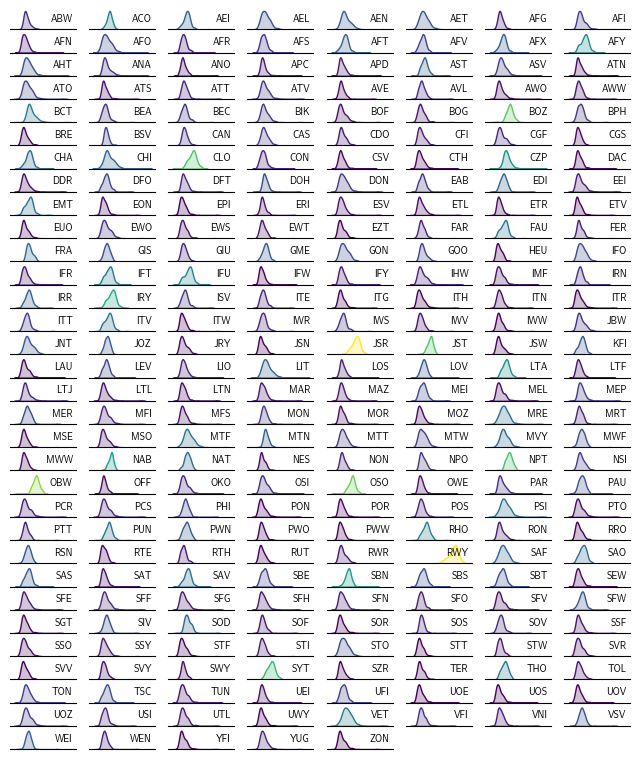

In [3]:
_df = exp

COLS = 8
ROWS = np.ceil(len(_df) / 8).astype(int)
fig, ax_fig = plt.subplots(ROWS, COLS, figsize=(1 * COLS, 0.3 * ROWS), sharex=True)

norm = plt.Normalize(0.3, 1.1)
cmap = cm.viridis

for ax, (label, row) in zip(ax_fig.reshape(-1), _df.iterrows()):
    color = cmap(norm(row.median()))
    sns.kdeplot(row.values, ax=ax, fill=True, color=color)
    ax.annotate(label, (0.95, 0.8), xycoords="axes fraction", ha="right", va="top", fontsize=7)


for ax in ax_fig.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in ax_fig.reshape(-1)[-3:]:
    ax.axis("off")
    
savefig(fig, "01-analysis-distributions.pdf")
plt.show()

## Correlations between distances

In [4]:
density_dist = squareform(pdist(efeat["density"].values.reshape(-1, 1)))

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_83363/2783461912.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


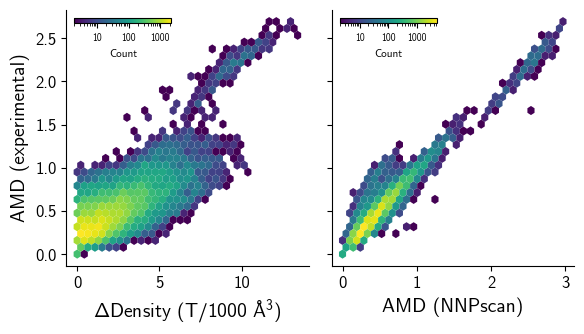

In [5]:
fig, ax_fig = plt.subplots(1, 2, figsize=(6, 3.5), sharey=True)

ax = ax_fig[0]
x = density_dist.reshape(-1)
y = exp.values.reshape(-1)

hb = ax.hexbin(
    x, 
    y,
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    bins="log"
)

cax = inset_axes(ax, width="40%", height="2%", loc="upper left")
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticks([10, 100, 1000])
cbar.set_ticklabels(cbar.get_ticks(), fontsize=7)
cbar.set_label("Count", fontsize=8)

ax.set_xlabel("ΔDensity (T/1000 Å$^3$)")
ax.set_ylabel("AMD (experimental)")


ax = ax_fig[1]

idx = sorted(list(set(exp.index) & set(nnp.index)))
x = nnp[idx].loc[idx].values.reshape(-1)
y = exp[idx].loc[idx].values.reshape(-1)

hb = ax.hexbin(
    x, 
    y,
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    bins="log"
)

cax = inset_axes(ax, width="40%", height="2%", loc="upper left")
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticks([10, 100, 1000])
cbar.set_ticklabels(cbar.get_ticks(), fontsize=7)
cbar.set_label("Count", fontsize=8)

ax.set_xlabel("AMD (NNPscan)")
# ax.set_ylabel("AMD (experimental)")

fig.tight_layout()
savefig(fig, "01-analysis-amd.pdf")
plt.show()

## Distance between previously computed metrics

In [6]:
past = pd.read_csv("https://raw.githubusercontent.com/learningmatter-mit/Zeolite-Graph-Similarity/master/data/zeolite_distances.csv")

# remove transformation matrices
past = past.drop([f"m{x}{i}{j}" for x, i, j in itertools.product(["A", "B"], [1, 2, 3], [1, 2, 3])], axis=1)

past = past.set_index(["Zeo1", "Zeo2"])

In [7]:
soap = past["SOAP"]
dmeasure = past["D"]

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_83363/3025857568.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


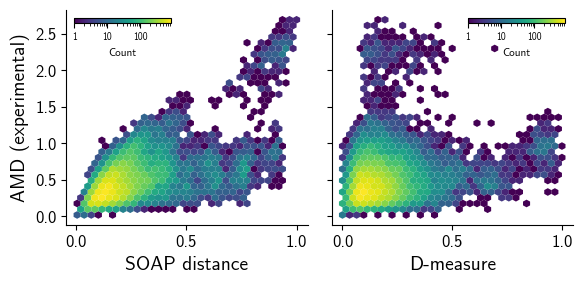

In [8]:
_exp = exp.stack()

idx = list(set(soap.index) & set(_exp.index))

y= _exp.loc[idx].values.reshape(-1)
x = soap.loc[idx].values.reshape(-1)

fig, ax_fig = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

ax = ax_fig[0]
hb = ax.hexbin(
    x, 
    y,
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    bins="log"
)
cax = inset_axes(ax, width="40%", height="2%", loc="upper left")
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticks([1, 10, 100])
cbar.set_ticklabels(cbar.get_ticks(), fontsize=7)
cbar.set_label("Count", fontsize=8)

ax.set_ylabel("AMD (experimental)")
ax.set_xlabel("SOAP distance")

ax = ax_fig[1]

x = dmeasure.loc[idx].values.reshape(-1)
hb = ax.hexbin(
    x, 
    y,
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    bins="log"
)
cax = inset_axes(ax, width="40%", height="2%", loc="upper right")
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticks([1, 10, 100])
cbar.set_ticklabels(cbar.get_ticks(), fontsize=7)
cbar.set_label("Count", fontsize=8)

ax.set_xlabel("D-measure")

fig.tight_layout()
savefig(fig, "01-analysis-soap.pdf")
plt.show()